In [1]:
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import numpy as np
import scanpy as sc
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import ranksums, kruskal
from concurrent.futures import ProcessPoolExecutor, as_completed
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from collections import defaultdict
import pingouin as pg
import joblib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
# Oligo NN in all slices
ct= 'Astro-TE NN'

In [3]:
annot = pd.read_hdf('/data/male-amb/MERFISH/MERFISH.integrated.01.hdf' )
annot = annot[annot['final_annot'] == ct]
annot['sample'] = annot.index.map(lambda x: '-'.join(x.split('-')[:-1]))
annot.head()

,volume,z,fov,experiment,region,slice,age,sample,n_counts,n_genes,blank_count,x,y,L1,L2,L2_transfer,merf_clust,merf_clust_tt,final_annot
cell,,,,,,,,,,,,,,,,,,,
C2-2mo-5_1,825.513794,7,5,202309011129_aging-mouse-2mo-slice-25_VMSC01101,region_0,C2,2mo,C2-2mo,40.0,24.0,0.0,324.190735,2504.009521,11.0,20.0,Astro-TE NN,r1_3_0,r1_3_0,Astro-TE NN
C2-2mo-6_7,480.265198,4,6,202309011129_aging-mouse-2mo-slice-25_VMSC01101,region_0,C2,2mo,C2-2mo,28.0,22.0,0.0,281.575378,2594.869141,11.0,20.0,Astro-TE NN,r1_3_0,r1_3_0,Astro-TE NN
C2-2mo-6_17,1087.918823,7,6,202309011129_aging-mouse-2mo-slice-25_VMSC01101,region_0,C2,2mo,C2-2mo,65.0,45.0,1.0,312.261841,2706.029297,11.0,20.0,Astro-TE NN,r1_3_0,r1_3_0,Astro-TE NN
C2-2mo-6_20,527.241943,3,6,202309011129_aging-mouse-2mo-slice-25_VMSC01101,region_0,C2,2mo,C2-2mo,21.0,15.0,0.0,252.470856,2713.178223,11.0,20.0,Astro-TE NN,r1_3_0,r1_3_0,Astro-TE NN
C2-2mo-6_30,645.234985,6,6,202309011129_aging-mouse-2mo-slice-25_VMSC01101,region_0,C2,2mo,C2-2mo,76.0,46.0,0.0,402.384918,2698.655273,11.0,20.0,Astro-TE NN,r1_3_0,r1_3_0,Astro-TE NN


In [4]:
annot['slice'].value_counts()

slice
C11    8914
C5     8766
C12    8714
C8     5826
C3     5619
C2     4141
C13    1172
Name: count, dtype: int64

In [5]:
# get a dict with keys as the Cxxx and values as the slices, order by 2mo, 9mo and 18mo
all_samples = annot['sample'].unique()
sample_dict = defaultdict(list)
for sample in all_samples:
    _slice = sample.split('-')[0]
    sample_dict[_slice].append(sample)
    # order the list by 2mo, 9mo and 18mo
    sample_dict[_slice].sort(key=lambda x: int(x.split('-')[1][:-2]))

# order the slices by number small to large
sample_dict = dict(sorted(sample_dict.items(), key=lambda x: int(x[0][1:])))
# remove C13
sample_dict.pop('C13')
sample_dict

{'C2': ['C2-2mo', 'C2-9mo', 'C2-18mo'],
 'C3': ['C3-2mo', 'C3-9mo', 'C3-18mo'],
 'C5': ['C5-2mo', 'C5-9mo', 'C5-18mo'],
 'C8': ['C8-2mo', 'C8-9mo', 'C8-18mo'],
 'C11': ['C11-2mo', 'C11-9mo-repeat', 'C11-18mo'],
 'C12': ['C12-2mo', 'C12-9mo-repeat', 'C12-18mo']}

In [6]:
#joblib.dump(sample_dict,'sample_dict')

In [7]:
all_results = joblib.load(f"result/{ct}_deg_result")

## plot

In [8]:
# get all from differents slices(keys) in all_results
all_degs = []
pvalue = 1e-20
log_fc = 0.3
for _slice in all_results.keys():
    deg_df = all_results[_slice]
    leg = sample_dict[_slice]
    deg_df[f'{_slice}.log2_18mo_2mo'] = np.log2((deg_df[f"{leg[2]}"] + 0.001)/(deg_df[f"{leg[0]}"] + 0.001))
    deg_list = list(deg_df[(deg_df[f'fdr'] < pvalue) & (np.abs(deg_df[f'{_slice}.log2_18mo_2mo']) > log_fc)].index)
    all_degs += deg_list

In [9]:
deg_counts = pd.Index(all_degs).value_counts()
common_degs = deg_counts[deg_counts >= 2].index
len(common_degs)

28

In [10]:
goi = ['Il33','Mobp','Neat1','Spock1','C4b']
#goi = ['Trem2','Nlrp3','Il18','Il1b','Apoe','App','Tff1','Psen1']
#goi = ['Meg3','Ighm']
#goi = ['Trem2','Nlrp3','Il18','Il1b','Apoe','App','Tff1','Psen1']
common_degs.intersection(goi)

Index(['Neat1', 'C4b'], dtype='object')

In [11]:
all_fc_df = []
all_fdr_df = []

for _slice in all_results.keys():
    deg_df = all_results[_slice]
    leg = sample_dict[_slice]
    deg_df[f'{_slice}.log2_18mo_2mo'] = np.log2((deg_df[f"{leg[2]}"] + 0.001)/(deg_df[f"{leg[0]}"] + 0.001))
    fc_df= deg_df.loc[:,[f'{_slice}.log2_18mo_2mo']]
    fdr_df = deg_df.loc[:,['fdr']]
    all_fdr_df.append(fdr_df)
    all_fc_df.append(fc_df)

all_fc_df = pd.concat(all_fc_df, axis=1)
all_fc_df.columns = all_results.keys()

all_fdr_df = pd.concat(all_fdr_df, axis=1)
all_fdr_df.columns = all_results.keys()


## plot scatter

In [12]:
# make it a long format, with columns as slice, genes,log2_fc
plot_fc_df = all_fc_df.loc[common_degs]
plot_fc_df = plot_fc_df.stack().reset_index()
plot_fc_df.columns = ['gene', 'slice', 'log2_fc']
plot_fc_df.head()

,gene,slice,log2_fc
0,Msi2,C2,1.025453
1,Msi2,C3,0.285143
2,Msi2,C5,0.900475
3,Msi2,C8,0.055717
4,Msi2,C11,0.304044


In [13]:
## use pg to apply fdr correction to all columns
#all_fdr_df = all_fdr_df.apply(lambda x: pg.multicomp(x, method='fdr_bh')[1])
all_fdr_df = all_fdr_df.fillna(1)
all_fdr_df= all_fdr_df +  1e-300
all_fdr_df = -np.log10(all_fdr_df)
all_fdr_df.head()

,C2,C3,C5,C8,C11,C12
gene,,,,,,
Msi2,99.007187,64.600586,152.125281,5.413940,99.230358,87.691497
Cxcl14,79.471027,48.288498,100.066164,72.232676,20.004663,28.608832
Sox9,48.959056,0.087770,40.104388,4.216581,17.773106,5.872539
Zfp219,41.180197,61.867008,65.576046,32.727718,160.845492,183.241570
Paqr8,38.949732,6.805022,86.933965,6.394965,32.037856,40.142739


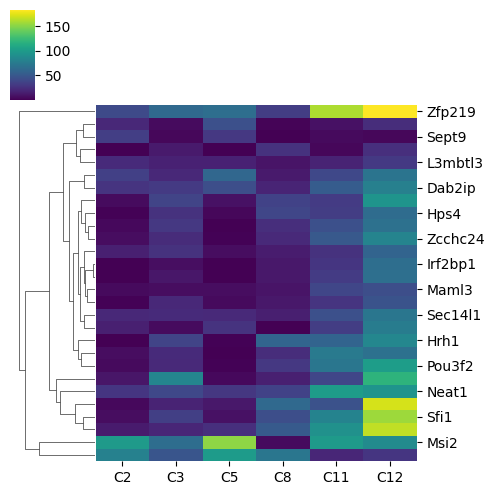

In [14]:
## cluster map and get the row order
clustermap_df = all_fdr_df.loc[common_degs]
g = sns.clustermap(clustermap_df, cmap='viridis', figsize=(5, 5), col_cluster=False, row_cluster=True)
# get the clustermap ordered gene list
gene_order = clustermap_df.index[g.dendrogram_row.reordered_ind]

In [15]:
plot_deg_df = all_fdr_df.loc[common_degs]
# make it a long format, with columns as slice, genes,-log10_fdr
plot_deg_df = plot_deg_df.stack().reset_index()
plot_deg_df.columns = ['gene', 'slice', '-log10_fdr']
plot_deg_df = pd.concat([plot_deg_df, plot_fc_df['log2_fc']], axis=1)

In [16]:
# sort the slice by sample_dict.keys() and cort gene by gene_order
plot_deg_df['slice'] = pd.Categorical(plot_deg_df['slice'], categories=sample_dict.keys(), ordered=True)
plot_deg_df['gene'] = pd.Categorical(plot_deg_df['gene'], categories=gene_order, ordered=True)
plot_deg_df = plot_deg_df.sort_values(['gene', 'slice'])
plot_deg_df.head()

,gene,slice,-log10_fdr,log2_fc
54,Zfp219,C2,41.180197,0.980443
55,Zfp219,C3,61.867008,-0.092772
56,Zfp219,C5,65.576046,0.859811
57,Zfp219,C8,32.727718,-0.018244
58,Zfp219,C11,160.845492,0.300631


In [17]:
f_plot_deg_df = plot_deg_df[plot_deg_df['-log10_fdr'] >= -np.log10(pvalue)]

In [20]:
size_norm_dict = {'Oligo NN':(50,200), 'Microglia NN':(10,50),'OPC NN':(10,50), 
                    'DG Glut':(5,30), 'Astro-NT NN':(10,50), 'Astro-TE NN':(10,50),'STR D2 Gaba':(10,50)}
hue_norm_dict = {'Oligo NN':(-0.5,0.5)}

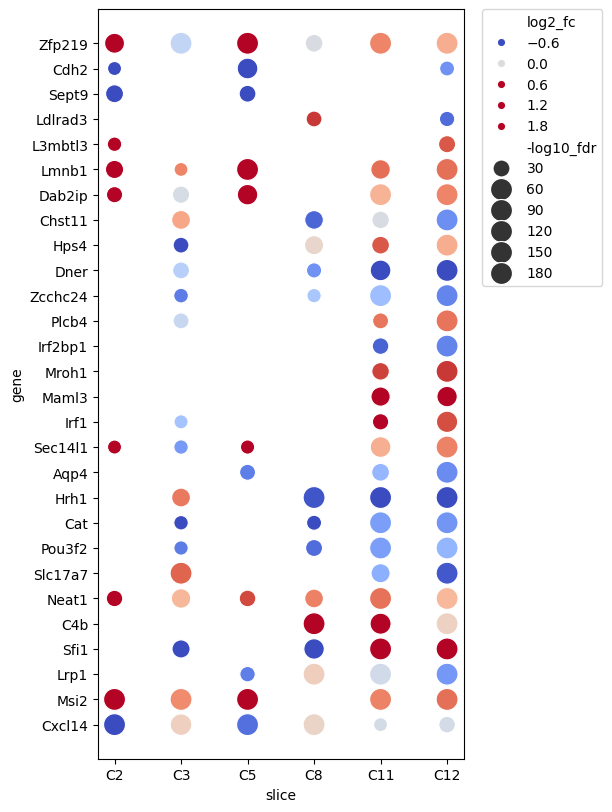

In [22]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

fig, ax = plt.subplots(figsize=(6,8), dpi = 100, constrained_layout = True)

sns.scatterplot(data=f_plot_deg_df,
                x='slice', 
                y='gene', rasterized = True,
                size='-log10_fdr', size_norm = size_norm_dict[ct],sizes=(50,250),
                hue='log2_fc', hue_norm = (-0.5,0.5),
                palette = 'coolwarm', 
                ax=ax )
                         
 # move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
fig.savefig(f"figure/{ct}.{pvalue}.{log_fc}.a_to_p.deg.pdf", bbox_inches='tight')                    

In [ ]:
pwd

'/home/qzeng_salk_edu/project/241107_merfish_analysis'